In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as data
from lightning.pytorch.callbacks import RichProgressBar
import lightning.pytorch as pl
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import ToyDataset
from torchdyn.utils import plot_2D_depth_trajectory, plot_2D_state_space, plot_2D_space_depth

In [2]:
n_samp = 512
dset_type = "moons"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dset = ToyDataset()
X, yn = dset.generate(n_samples=n_samp, dataset_type=dset_type, noise=0.1)
df = pd.DataFrame({"x1": X[:, 0], "x2": X[:, 1], "lab": yn})

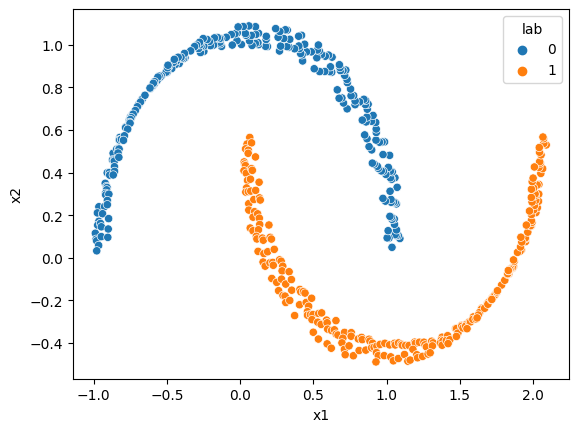

In [4]:
sns.scatterplot(df, x="x1", y="x2", hue="lab")
plt.show()

In [5]:
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=len(X), shuffle=True)

In [6]:
class LitModel(pl.LightningModule):
    def __init__(self, n_ode: nn.Module, t_span: torch.Tensor):
        super().__init__()
        self.n_ode, self.t_span = n_ode, t_span
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, t_span):
        return self.n_ode(x, t_span)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, yhat = self.n_ode(x, self.t_span)
        # Select last point of solution trajectory
        yhat = yhat[-1]
        loss = self.loss(yhat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        return {"loss": loss}

    def configure_optimizers(self):
        return Adam(self.n_ode.parameters(), lr=0.01)

In [7]:
input_dim = X_train.shape[1]
hidden_dim = 64
n_epochs = 100

In [8]:
f = nn.Sequential(
    DepthCat(-1),
    nn.Linear(input_dim + 1, hidden_dim),
    nn.Tanh(),
    DepthCat(1),
    nn.Linear(hidden_dim + 1, 2)
)
t_span = torch.linspace(0, 1, 2)

In [9]:
n_ode = NeuralODE(f, sensitivity='adjoint', solver='tsit5', atol=1e-3, rtol=1e-3)
model = LitModel(n_ode, t_span)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [10]:
accelerator = "gpu" if device.type == "cuda" else "cpu"

In [11]:
trainer_dev = pl.Trainer(accelerator=accelerator, fast_dev_run=1, callbacks=[RichProgressBar()])
trainer_dev.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/carcook/anaconda3/envs/torchdyn-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ n_ode │ NeuralODE        │    388 │
│ 1 │ loss  │ CrossEntropyLoss │      0 │
└───┴───────┴──────────────────┴────────┘

Trainable params: 388                                                                                              
Non-trainable params: 0                                                                                            
Total params: 388                                                                                                  
Total estimated model params size (MB): 0

Output()

/home/carcook/anaconda3/envs/torchdyn-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carcook/anaconda3/envs/torchdyn-env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_steps=1` reached.


In [12]:
trainer = pl.Trainer(
    accelerator=accelerator,
    max_epochs=n_epochs,
    gradient_clip_algorithm="norm",
    gradient_clip_val=1.0,
    callbacks=[RichProgressBar()],
    default_root_dir="lightning_logs_depth_var"
)
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs_depth_var/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ n_ode │ NeuralODE        │    388 │
│ 1 │ loss  │ CrossEntropyLoss │      0 │
└───┴───────┴──────────────────┴────────┘

Trainable params: 388                                                                                              
Non-trainable params: 0                                                                                            
Total params: 388                                                                                                  
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
t_span_plt = torch.linspace(0, 1, 100)
t_eval, trajectory = model(X_train.to("cpu"), t_span_plt)
trajectory = trajectory.detach()

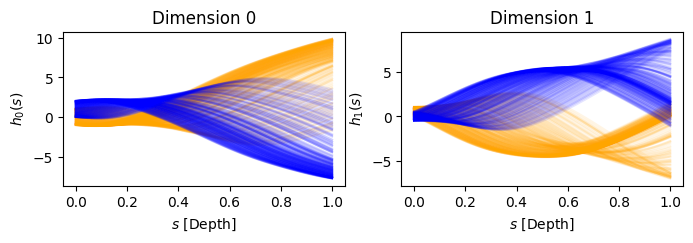

In [14]:
plot_2D_depth_trajectory(t_span_plt, trajectory, yn, len(X))

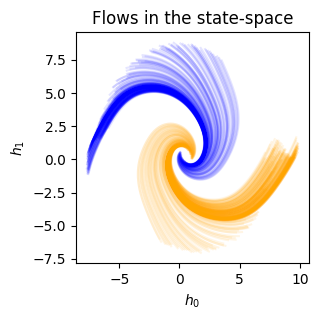

In [16]:
plot_2D_state_space(trajectory, yn, len(X))

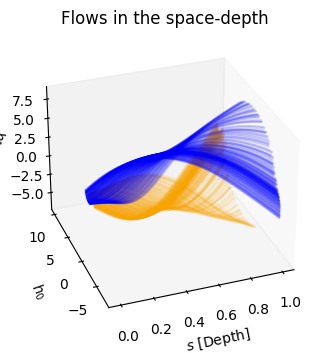

In [15]:
plot_2D_space_depth(t_span_plt, trajectory, yn, len(X))